# Starter Notebook

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

## Load Tokenizer and Preprocess Data

In [3]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [4]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [5]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [6]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [7]:
# # PEFT Config
# peft_config = LoraConfig(
#     r=2,
#     lora_alpha=4,
#     lora_dropout=0.05,
#     bias = 'none',
#     target_modules = ['query'],
#     task_type="SEQ_CLS",
# )

# Configure LoRA
peft_config = LoraConfig(
    r=7,  # LoRA rank
    lora_alpha=16,  # Alpha parameter for scaling
    lora_dropout=0.05, # Dropout probability for LoRA layers
    target_modules=["query", "key", "value"], # Apply LoRA to these layers
    bias="none",  # Don't train bias parameters
    task_type="SEQ_CLS", # Specify the task type
)

In [8]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): Mo

In [9]:
# print("Trainable parameters:")
# for name, param in peft_model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [10]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807


## Training Setup

In [11]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [12]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=None,
    eval_strategy='steps',
    logging_steps=100,
    learning_rate=1e-5,
    num_train_epochs=1,
    max_steps=1200,
    use_cpu=False,
    dataloader_num_workers=4,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)

def get_trainer(model):
    return Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        data_collator=data_collator,
    )

### Start Training

In [13]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refe

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: dataencapsulate (dataencapsulate-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
100,1.385100,1.382159,0.337500
200,1.376300,1.371319,0.556250
300,1.363200,1.356276,0.648438
400,1.343400,1.325836,0.837500
500,1.298900,1.258590,0.882812
600,1.187100,1.088900,0.878125
700,0.965100,0.797736,0.879687
800,0.788000,0.643362,0.882812
900,0.661900,0.552882,0.885938
1000,0.596000,0.504718,0.887500


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: T

## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [14]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    output = model(**inputs)

    prediction = output.logits.argmax(dim=-1).item()

    print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
    return id2label[prediction]

In [15]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

 Class: 2, Label: Business, Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.


'Business'

### Run Inference on eval_dataset

In [16]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [17]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:11<00:00,  6.91it/s]

Evaluation Metric: {'accuracy': 0.8890625}


### Run Inference on unlabelled dataset

In [19]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [20]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [01:51<00:00,  8.96it/s]

Inference complete. Predictions saved to inference_output.csv


In [21]:
# %% Cell 1: Compute predictions, overall & per‐class metrics, and class distribution
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# 1. Run predictions on validation set
pred_output = peft_lora_finetuning_trainer.predict(eval_dataset)
preds = np.argmax(pred_output.predictions, axis=1)
labels = pred_output.label_ids

# 2. Overall performance + per‐category metrics
report = classification_report(labels, preds,
                               target_names=list(id2label.values()),
                               output_dict=True)
report_df = pd.DataFrame(report).transpose()
print("\n=== Classification Report ===")
print(report_df)

# 3. Predicted class distribution
class_dist = pd.Series(preds).value_counts().sort_index().rename_axis('class_id').reset_index(name='count')
class_dist['class_name'] = class_dist['class_id'].map(id2label)
print("\n=== Predicted Class Distribution ===")
print(class_dist)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(



=== Classification Report ===
              precision    recall  f1-score     support
World          0.885714  0.855172  0.870175  145.000000
Sports         0.950000  0.962025  0.955975  158.000000
Business       0.870130  0.875817  0.872964  153.000000
Sci/Tech       0.854839  0.864130  0.859459  184.000000
accuracy       0.889062  0.889062  0.889062    0.889062
macro avg      0.890171  0.889286  0.889643  640.000000
weighted avg   0.888982  0.889062  0.888943  640.000000

=== Predicted Class Distribution ===
   class_id  count class_name
0         0    140      World
1         1    160     Sports
2         2    154   Business
3         3    186   Sci/Tech


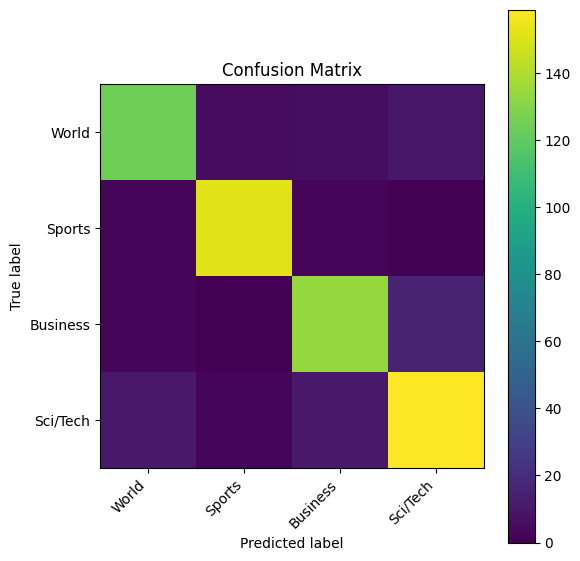

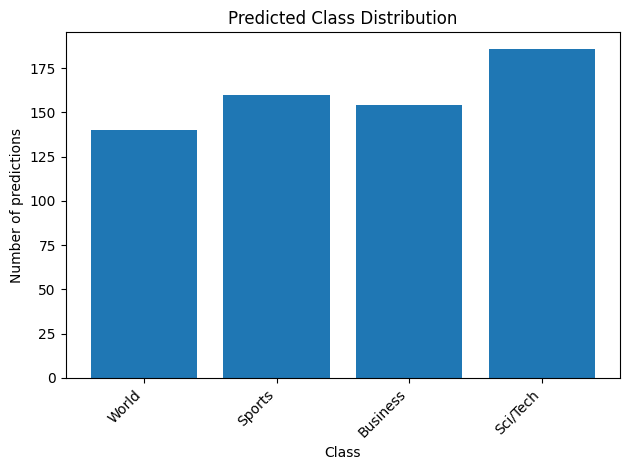

In [22]:
# %% Cell 2: Confusion matrix & class‐distribution bar chart
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Confusion matrix
conf_mat = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(conf_mat, interpolation='nearest')
ax.set_xticks(np.arange(len(id2label)))
ax.set_yticks(np.arange(len(id2label)))
ax.set_xticklabels(list(id2label.values()), rotation=45, ha='right')
ax.set_yticklabels(list(id2label.values()))
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_title("Confusion Matrix")
fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# Class distribution bar plot
fig, ax = plt.subplots()
ax.bar(class_dist['class_name'], class_dist['count'])
ax.set_xlabel("Class")
ax.set_ylabel("Number of predictions")
ax.set_title("Predicted Class Distribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


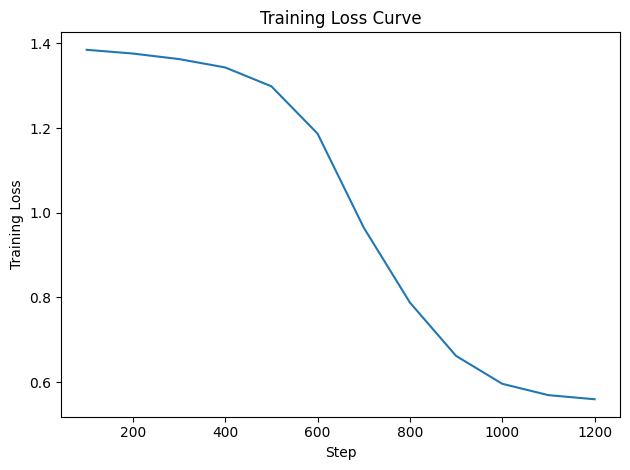

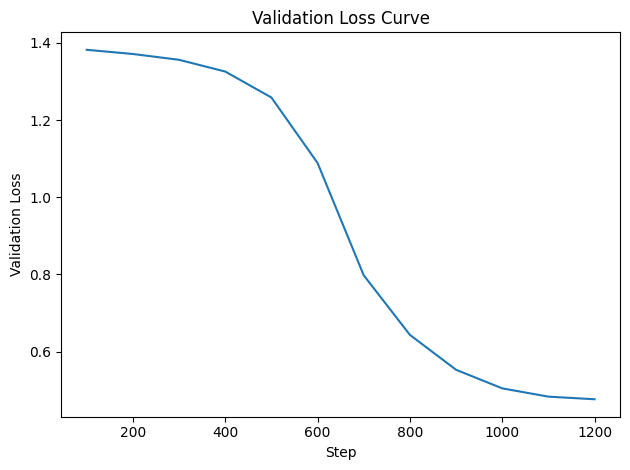

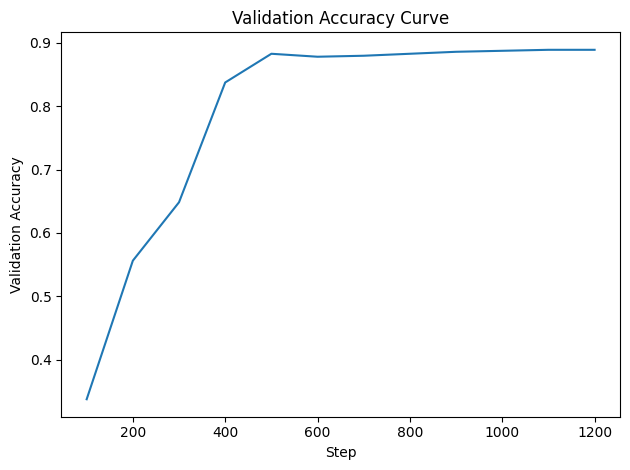

In [23]:
# %% Cell 3: Training & validation loss/accuracy curves
import matplotlib.pyplot as plt

# Extract from trainer state
history = peft_lora_finetuning_trainer.state.log_history

# Training loss entries (ones with 'loss' but no 'eval_loss')
train_steps  = [e['step'] for e in history if 'loss' in e and 'eval_loss' not in e]
train_losses = [e['loss'] for e in history if 'loss' in e and 'eval_loss' not in e]

# Validation metrics (those with 'eval_loss' and 'eval_accuracy')
eval_steps  = [e['step'] for e in history if 'eval_loss' in e]
eval_losses = [e['eval_loss'] for e in history if 'eval_loss' in e]
eval_accs   = [e['eval_accuracy'] for e in history if 'eval_accuracy' in e]

# Plot training loss
plt.figure()
plt.plot(train_steps, train_losses)
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("Training Loss Curve")
plt.tight_layout()
plt.show()

# Plot validation loss
plt.figure()
plt.plot(eval_steps, eval_losses)
plt.xlabel("Step")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Curve")
plt.tight_layout()
plt.show()

# Plot validation accuracy
plt.figure()
plt.plot(eval_steps, eval_accs)
plt.xlabel("Step")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Curve")
plt.tight_layout()
plt.show()


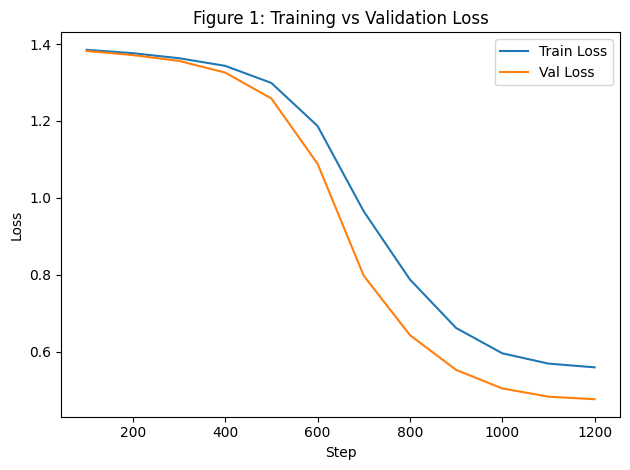

In [24]:
# %% Cell: Combined Loss Curve (Figure 1)
import matplotlib.pyplot as plt

# extract from your trainer state, as before
history = peft_lora_finetuning_trainer.state.log_history
train_steps  = [e['step']     for e in history if 'loss' in e and 'eval_loss' not in e]
train_losses = [e['loss']     for e in history if 'loss' in e and 'eval_loss' not in e]
eval_steps   = [e['step']     for e in history if 'eval_loss' in e]
eval_losses  = [e['eval_loss'] for e in history if 'eval_loss' in e]

plt.figure()
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(eval_steps, eval_losses, label='Val Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Figure 1: Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


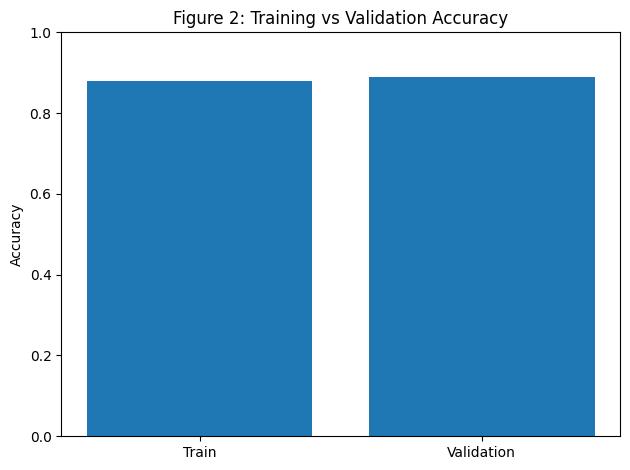

In [26]:
# %% Cell: Figure 2 – Training vs Validation Accuracy
# 1) Get train & val accuracy in one pass each
train_pred = peft_lora_finetuning_trainer.predict(train_dataset)
val_pred   = peft_lora_finetuning_trainer.predict(eval_dataset)

# Depending on your HF version the metric key may be 'test_accuracy' or 'eval_accuracy'
train_acc = train_pred.metrics.get('test_accuracy', train_pred.metrics.get('eval_accuracy'))
val_acc   = val_pred.metrics.get('test_accuracy',   val_pred.metrics.get('eval_accuracy'))

# 2) Plot bar chart
import matplotlib.pyplot as plt

plt.figure()
plt.bar(['Train','Validation'], [train_acc, val_acc])
plt.ylim(0, 1.0)
plt.ylabel('Accuracy')
plt.title('Figure 2: Training vs Validation Accuracy')
plt.tight_layout()
plt.show()
